# Mars Landing Site Identification
MAT 494, Spring 2023

### Base setup

In [76]:
# base libraries
import numpy as np
from matplotlib import pyplot as plt
import math

# note: cv2 is deprecated, and opencv doesn't appear to install on the conda forge registry?
# import opencv


### Data loading

In [77]:
# file paths
# OFFICIAL resolution: (2880, 5760)
elev_file ="test_data/megt90n000fb.img"
dust_file = "test_data/dci_lo_ice_dust_16ppd_shifted.raw"
TI_file = "test_data/ti16"
alb_file = "test_data/alb32"

In [78]:
def load_elevation(file):
    with open(file,"rb") as f:
        dat = f.read()
        z=np.frombuffer(dat, dtype='>i2').reshape(720*8,1440*8).astype(np.float64)
        
    return z

In [79]:
def load_dci(file):
    with open(file,"rb") as f:
        dat = f.read()
    dci = np.frombuffer(dat,dtype=np.float32).reshape(2880,5760)
    return dci

In [80]:
def load_TI(file, VICAR_LBLSIZE=11520):
    with open(file,"rb") as f:
        dat = f.read()
    ti = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.int32).reshape(1440,2880)
    return ti

In [81]:
def load_alb(file, VICAR_LBLSIZE=11520):
    with open(file,"rb") as f:
        dat = f.read()
    alb = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.float32).reshape(1440,2880)
    return alb

In [82]:
def roll_dci(dci, ROLL=2880):
    return np.roll(dci, ROLL, axis=1)

In [83]:
def downsample_elevation(elev):
    return elev[0::2,0::2]

In [84]:
def scale_up(arr):
    # Nearest Neighbor interpolation
    new_arr = np.zeros((2880, 5760))
    
    new_arr[0::2,0::2] = arr
    new_arr[1::2,0::2] = arr
    new_arr[0::2,1::2] = arr
    new_arr[1::2,1::2] = arr
    
    return new_arr

In [85]:
# Load Files
elev = load_elevation(elev_file)
dci = load_dci(dust_file)
ti = load_TI(TI_file)
alb = load_alb(alb_file)

# Pre Process
elev = downsample_elevation(elev)
dci = roll_dci(dci)
ti = scale_up(ti)
alb = scale_up(alb)

assert elev.shape == dci.shape == ti.shape == alb.shape

In [86]:
elev[0::2,0::2].shape

(1440, 2880)

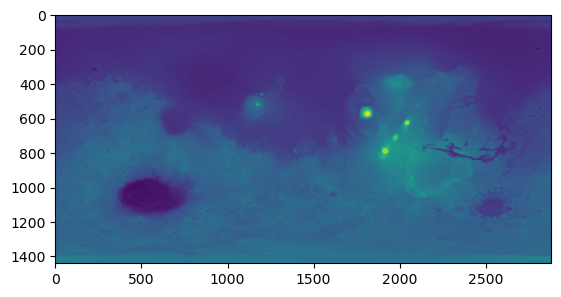

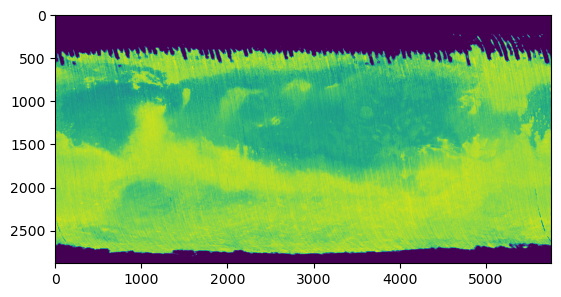

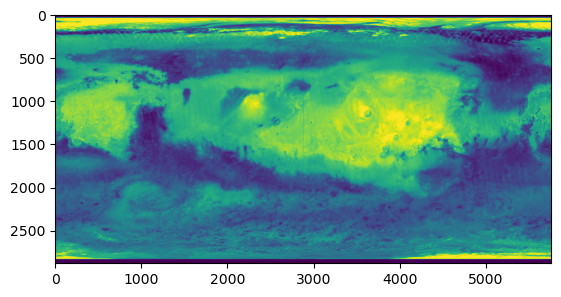

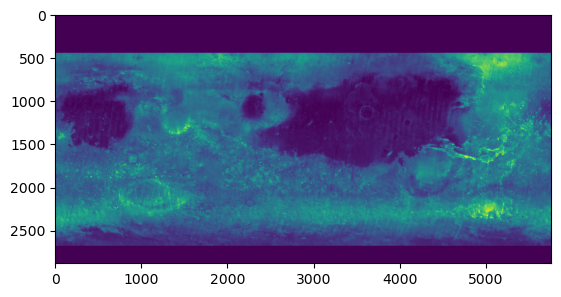

In [87]:
plt.imshow(elev[0::2,0::2])
plt.show()
plt.imshow(dci)
plt.show()
plt.imshow(alb)
plt.show()
plt.imshow(ti)
plt.show()

In [88]:
elev<0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

np.frombuffer(dat).reshape(5760,2880)

In [89]:
33177600/5760

5760.0

### Constraint identification

In [90]:
# setting up conditions
# elevation (km)
min_elev = -(math.inf)
max_elev = -1.3

# thermal inertia (TI)
min_ti = 200
max_ti = 250
# min_ti = 1
# max_ti = math.inf

# albedo
min_alb = 0.18
max_alb = 0.26

# dust cover index (DCI)
min_dci = 0.93
max_dci = 0.97

### Filters

#### Boolean filters

In [91]:
# boolean filtering
elev_mask = [(elev > min_elev) & (elev <= max_elev)][0]
ti_mask = [(ti > min_ti) & (ti <= max_ti)][0]
alb_mask = [(alb > min_alb) & (alb <= max_alb)][0]
dci_mask = [(dci > min_dci) & (dci <= max_dci)][0]

# alternative mask for ti and alb
alt_mask = ti > (300 * alb + 180)

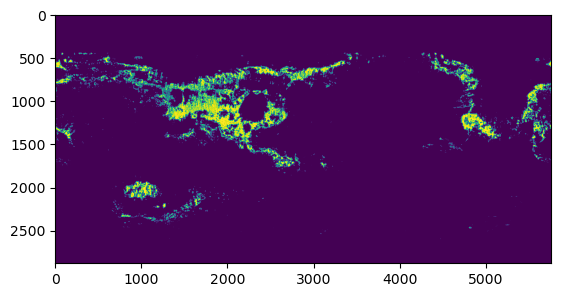

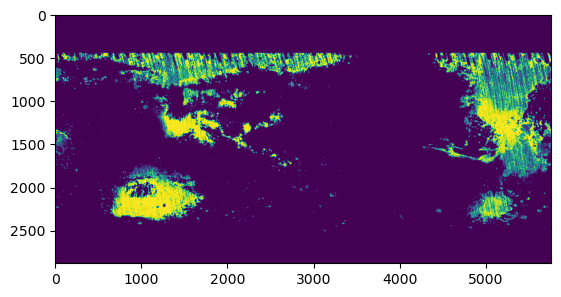

In [92]:
plt.imshow(elev_mask & ti_mask & alb_mask & dci_mask)
plt.show()
plt.imshow(elev_mask & alt_mask & dci_mask)
plt.show()

#### Spatial filters

In [93]:
# convert given latitude to absolute measure
def absolute_latitude(latitude):
    # positive: find distance from top
    if latitude > 0:
        return 90 - latitude
    # negative: find cumulative distance from top
    else:
        return abs(latitude) + 90

In [94]:
# find image's vertical interval equivalent to a latitudinal slice
def latitude_intervals(bottom, top, dim_y):
    # per-degree equivalence factor
    factor = dim_y / 180

    # convert latitudes
    new_bottom = absolute_latitude(bottom) * factor
    new_top = absolute_latitude(top) * factor

    # remove rounding errors
    return (round(new_bottom), round(new_top))

In [95]:
# generate the boolean latitude mask
def latitude_mask(bottom, top, dim_x, dim_y):
    # empty boolean mask
    base_mask = np.full((dim_x, dim_y), False)

    # get correct latitudes
    (new_bottom, new_top) = latitude_intervals(bottom, top, dim_x)

    # iterate over latitude interval to make mask
    for x in range(new_top, new_bottom, 1):
        for y in range(len(base_mask[0])):
            base_mask[x][y] = True
    
    # done
    return base_mask

In [96]:
# convert given longitude to absolute measure
def absolute_longitude(longitude):
    # positive: find distance from top
    if longitude > 0:
        return 180 + longitude
    # negative: find cumulative distance from top
    else:
        return 180 - abs(longitude)

In [97]:
# find image's vertical interval equivalent to a latitudinal slice
def longitude_intervals(left, right, dim_y):
    # per-degree equivalence factor
    factor = dim_y / 360

    # convert latitudes
    new_left = absolute_longitude(left) * factor
    new_right = absolute_longitude(right) * factor
    
    # remove rounding errors
    return (round(new_left), round(new_right))

In [98]:
# generate the boolean latitude mask
def longitude_mask(left, right, dim_x, dim_y):
    # empty boolean mask
    base_mask = np.full((dim_x, dim_y), False)

    # get correct latitudes
    (new_left, new_right) = longitude_intervals(left, right, dim_y)

    # iterate over latitude interval to make mask
    for x in range(len(base_mask)):
        for y in range(new_left, new_right + 1, 1):
            base_mask[x][y] = True
    
    # done
    return base_mask

In [99]:
# example mask: -30deg South, 60deg North
lat_mask = latitude_mask(-30, 60, 2880, 5760)

# example mask: -90deg West, 90deg East
lon_mask = longitude_mask(-90, 90, 2880, 5760)

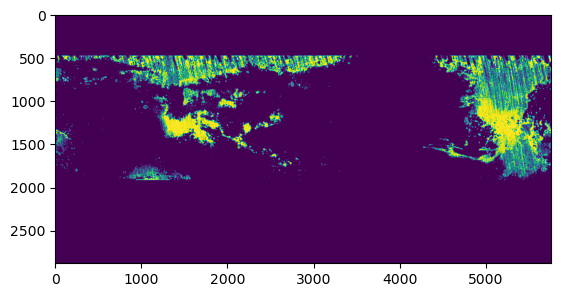

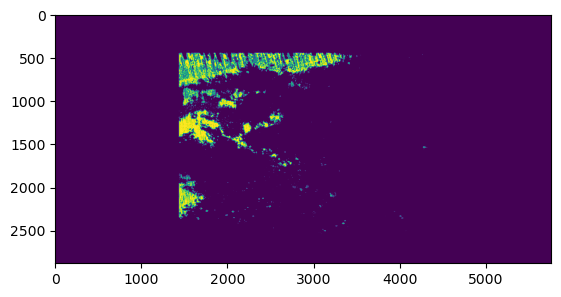

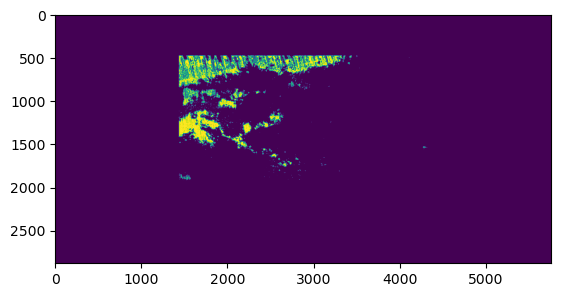

In [100]:
# testing latitudinal mask
plt.imshow(elev_mask & alt_mask & dci_mask & lat_mask)
plt.show()
# testing latitudinal mask
plt.imshow(elev_mask & alt_mask & dci_mask & lon_mask)
plt.show()
# testing latitudinal mask
plt.imshow(elev_mask & alt_mask & dci_mask & lat_mask & lon_mask)
plt.show()